In [ ]:
# Importing Libraries
# ======================
import numpy as np
import cv2
import requests
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from joblib import dump, load
from PIL import Image



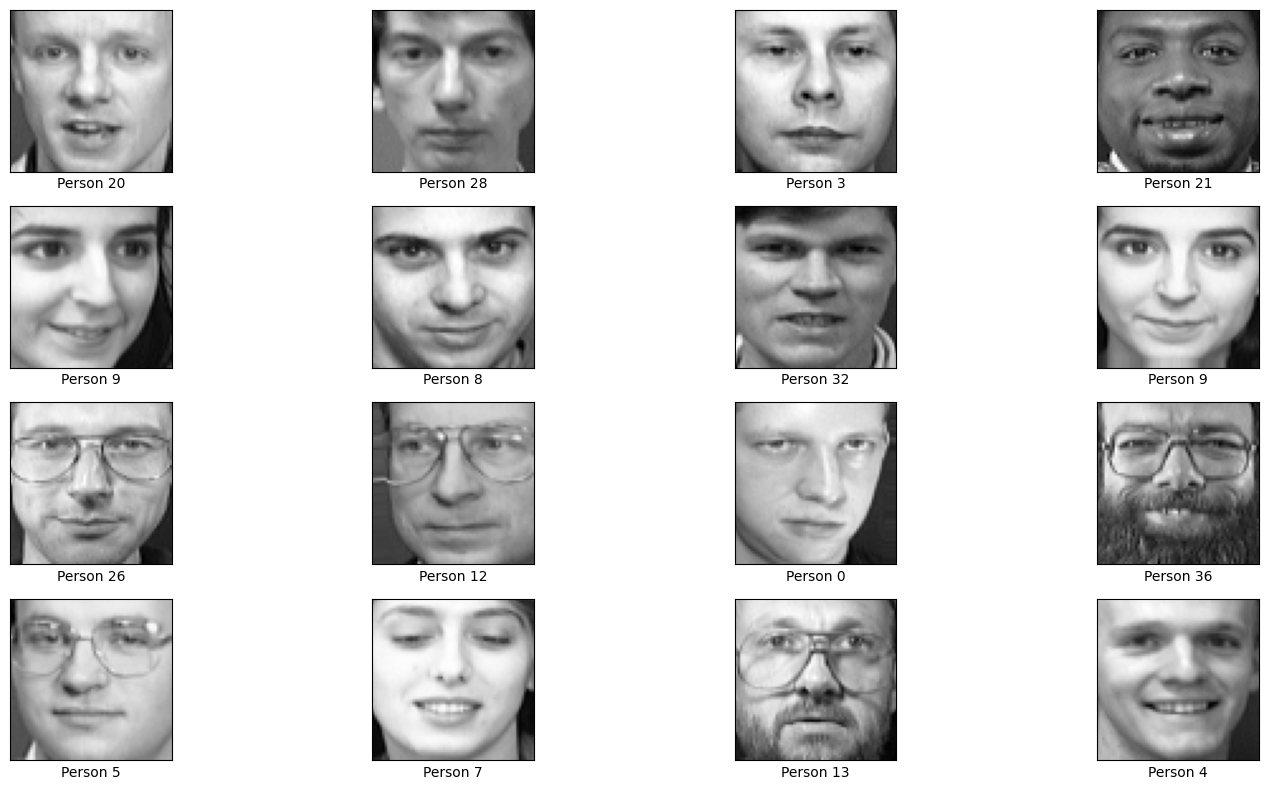

In [37]:
#Load dataset
faces=fetch_olivetti_faces(shuffle=True, random_state=42)
X=faces.data
y=faces.target #labels 0-39

#Display some sample faces
fig,axes = plt.subplots(4, 4, figsize=(16, 8))
for i,ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(64, 64), cmap="gray")
    ax.set(xticks=[], yticks=[], xlabel=f"Person {y[i]}")
plt.tight_layout()
plt.show()

In [ ]:
#Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction (using PCA)-->PCA= Principal component analysis
pca =PCA(n_components=0.95, whiten=True, random_state=42)
X_pca =pca.fit_transform(X_scaled)

print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"Reduced dimensions: {X_pca.shape[1]}")


Original dimensions: 4096
Reduced dimensions: 123


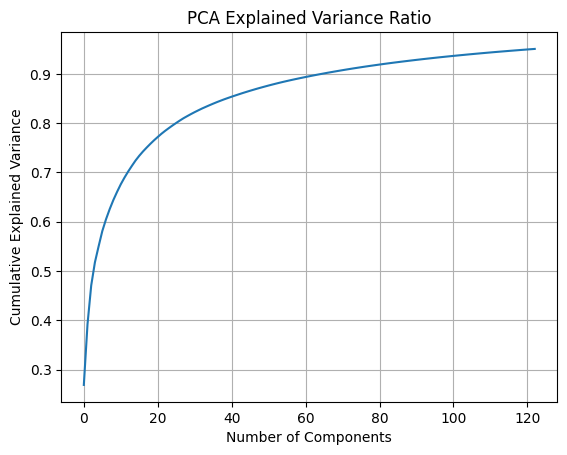

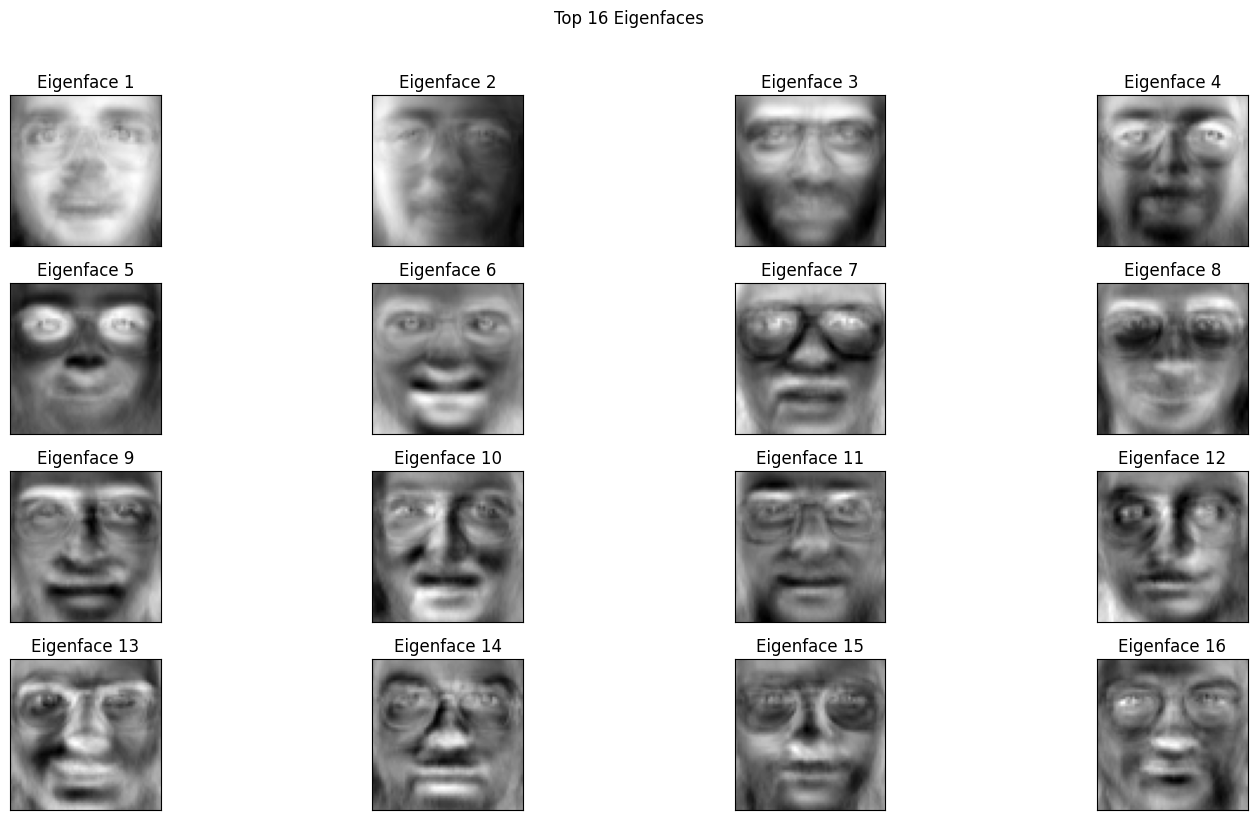

In [ ]:
#Plot to explaine variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Ratio")
plt.grid()
plt.show()

# Visualizing some of the eigenfaces
eigenfaces =pca.components_.reshape(-1, 64, 64)
fig,axes=plt.subplots(4, 4, figsize=(16, 8))
for i,ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set(xticks=[], yticks=[], title=f"Eigenface {i+1}")
plt.tight_layout()
plt.show()

In [ ]:
#Model Training
#Use StratifiedShuffleSplit to preserve class balance and better data splitting
splitter=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx,test_idx in splitter.split(X_pca, y):
    X_train,X_test =X_pca[train_idx], X_pca[test_idx]
    y_train,y_test =y[train_idx], y[test_idx]

#Hyperparameter tuning for SVM
#Use GridSearchCV to find the best kernel and C value.
param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid=GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5)
grid.fit(X_train, y_train)
clf=grid.best_estimator_
print(f"Best SVM parameters: {grid.best_params_}")

#Evaluate
y_pred=clf.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Best SVM parameters: {'C': 0.1, 'kernel': 'linear'}
Test Accuracy: 0.94


In [38]:
#Save the model to use whenever you want; skipping the previous steps
dump(clf,'face_recognition_model.joblib')
dump(scaler,'scaler.joblib')
dump(pca,'pca.joblib')


['pca.joblib']

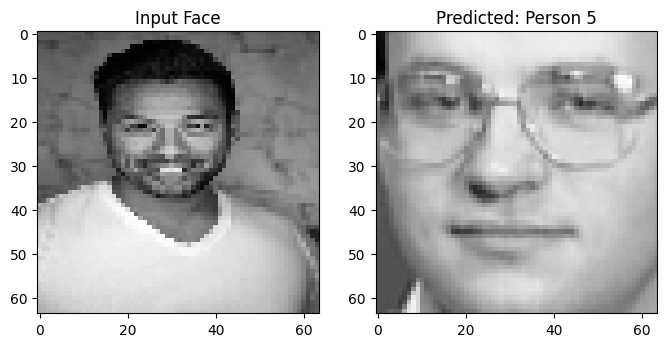

np.int64(5)

In [ ]:
# # Run this part if you want to test on new faces
# def process_new_face(image_url):
#     #Load the image
#     respons=requests.get(image_url, stream=True)
#     img=Image.open(response.raw)
#     img=np.array(img)
#     #Convertion to grayscale and resizing the image
#     gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     resized=cv2.resize(gray, (64, 64))

#     #Preprocessing
#     flattened=resized.reshape(1, -1)
#     scaled=scaler.transform(flattened)
#     projected=pca.transform(scaled)

#     #Prediction
#     pred=clf.predict(projected)[0]

#     #Visualization
#     plt.figure(figsize=(8, 4))
#     plt.subplot(1, 2, 1)
#     plt.imshow(resized, cmap='gray')
#     plt.title("Input Face")
#     plt.subplot(1, 2, 2)
#     closest_match = X[y == pred][0].reshape(64, 64)
#     plt.imshow(closest_match, cmap='gray')
#     plt.title(f"Predicted: Person {pred}")
#     plt.show()

#     return pred

# #A random internet face
# test_url="https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=80"
# process_new_face(test_url)

In [ ]:
# Later Uses: Load pre-trained models:
# clf = load('face_recognition_model.joblib')
# scaler = load('scaler.joblib')
# pca = load('pca.joblib')